In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

dataframe = genfromtxt('train.csv', delimiter=',', skip_header=True)


In [2]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

In [3]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

In [4]:
X_test.shape
y.shape

(42000, 1)

In [15]:
import tensorflow as tf

def dense(input_size, output_size, mean=0.0, stddev=0.01, dtype=tf.float32, activation_type=None):
    weight_tensor = tf.Variable(tf.random_normal(shape=(input_size, output_size),
                                                mean=mean, stddev=stddev, dtype=dtype))
    
    bias_tensor = tf.Variable(tf.zeros(output_size))
    
    def apply_dense(X):
        result = tf.add(tf.matmul(X, weight_tensor), bias_tensor)
        return activation_type(result) if activation_type != None else result

    return apply_dense
        

In [6]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [7]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)

In [26]:
def nn():
    
    l1 = dense(int(input_.shape[1]), 32, activation_type=tf.nn.relu)(input_)
    l2 = dense(int(l1.shape[1]), 16, activation_type=tf.nn.relu)(l1)
    l3 = dense(int(l2.shape[1]), 32, activation_type=tf.nn.relu)(l2)
    
    l4 = combine(l1, l3)
    l5 = dense(int(l4.shape[1]), 16, activation_type=tf.nn.relu)(l4)
    
    out = dense(int(l5.shape[1]), 10)(l5)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [27]:
def get_next_batch(batch_size, X, y):
    for i in range(int(y.shape[0]/batch_size)-1):
        yield X[i: i+batch_size, :] , y[i: i+batch_size]

In [28]:
cost, optimizer, output = nn()

In [29]:
from sklearn.metrics import accuracy_score

# Initialize tensorflow session
init = tf.global_variables_initializer()

epochs = 100
batch_size = 64
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
cost_curr = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    #plt.ion()
    # Training cycle
    current_placeholder_value = 0.001
    
    for epoch in range(epochs):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value})
            
        c = sess.run(cost, feed_dict={input_: x, labels: y, learning_rate_ph:current_placeholder_value})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        
        # Find train accuracy
        y_predicted_train_fold = np.argmax(output.eval(feed_dict={input_: X_train_fold, labels: y_train_fold, learning_rate_ph:current_placeholder_value}), 1)
        current_train_acc = accuracy_score(y_true=y_train_fold, y_pred=y_predicted_train_fold)
        
        train_accuracy.append(current_train_acc)
        
        print("Train Accuracy:", current_train_acc)
        
        # Find the validation accuracy
        y_predicted_val_fold = np.argmax(output.eval(feed_dict={input_: X_val_fold, labels: y_val_fold, learning_rate_ph:current_placeholder_value}), 1)
        current_val_acc = accuracy_score(y_true=y_val_fold, y_pred=y_predicted_val_fold)
        
        val_accuracy.append(current_val_acc)
        
        print("Validation Accuracy:", current_val_acc)
        print()
        
        cost_curr.append(c)
        
        #if (epoch > 0 and  epoch % 10 == 0):
         #   current_placeholder_value = 1.001*current_placeholder_value
        
        #plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
        #plt.show()
    
    print("Optimization Finished!")
    
    
    # Find test accuracy
    y_predicted_test = np.argmax(output.eval(feed_dict={input_: X_test, labels: y_test}), 1)
    print("Test Accuracy:", accuracy_score(y_true=y_test, y_pred=y_predicted_test))

Epoch: 0001 cost= 2.172001600
Train Accuracy: 0.158552659552
Validation Accuracy: 0.166836734694

Epoch: 0002 cost= 0.912872493
Train Accuracy: 0.590161146307
Validation Accuracy: 0.587244897959

Epoch: 0003 cost= 0.251244098
Train Accuracy: 0.71359326502
Validation Accuracy: 0.713265306122

Epoch: 0004 cost= 0.153925925
Train Accuracy: 0.72660402228
Validation Accuracy: 0.723299319728

Epoch: 0005 cost= 0.116762266
Train Accuracy: 0.807134657086
Validation Accuracy: 0.80731292517

Epoch: 0006 cost= 0.115687571
Train Accuracy: 0.806284280794
Validation Accuracy: 0.797619047619

Epoch: 0007 cost= 0.095302030
Train Accuracy: 0.833241209235
Validation Accuracy: 0.821088435374

Epoch: 0008 cost= 0.080269277
Train Accuracy: 0.835749819295
Validation Accuracy: 0.837925170068

Epoch: 0009 cost= 0.031113096
Train Accuracy: 0.864407500319
Validation Accuracy: 0.865136054422

Epoch: 0010 cost= 0.166495115
Train Accuracy: 0.823929588843
Validation Accuracy: 0.816326530612

Epoch: 0011 cost= 0.022

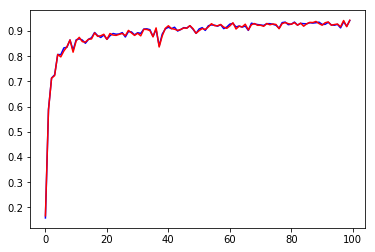

In [30]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-')
plt.show()

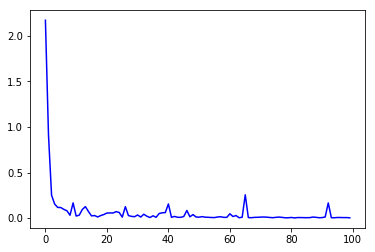

In [31]:
plt.plot(cost_curr, 'b-')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

array([[1236,    0,    2,    4,    0,    5,    9,    2,    3,    2],
       [   0, 1356,   11,   10,    0,    2,    4,    3,   23,    1],
       [  12,    1, 1168,   18,    3,    0,    7,    3,   11,    3],
       [   2,    9,   32, 1199,    1,   38,    5,    8,   16,    7],
       [   9,    5,    4,    0, 1117,    3,    7,    2,   10,   27],
       [  15,    3,    3,   22,    6, 1047,   20,    3,   12,    4],
       [  34,    2,   17,    2,   21,   13, 1131,    0,    6,    1],
       [   8,    5,   26,    4,    3,    5,    0, 1259,    5,   17],
       [  13,   13,   14,   13,    5,   21,   12,    1, 1129,   14],
       [  13,    4,    2,   16,   48,   14,    0,   42,   19, 1114]])

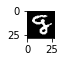

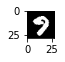

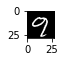

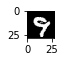

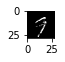

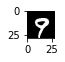

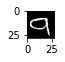

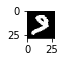

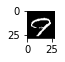

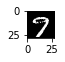

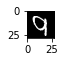

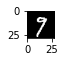

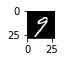

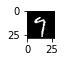

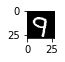

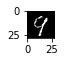

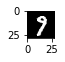

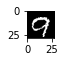

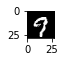

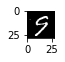

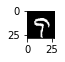

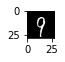

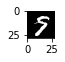

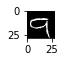

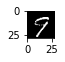

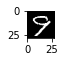

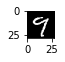

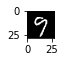

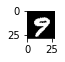

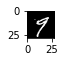

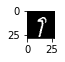

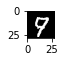

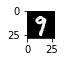

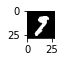

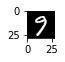

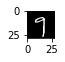

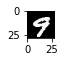

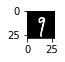

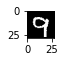

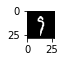

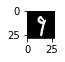

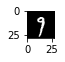

In [33]:
indices = np.where(np.logical_and(y_predicted_test == 7, y_test.squeeze() == 9))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()